In [1]:
!pip install livelossplot

In [38]:
import os
import joblib
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report
from livelossplot import PlotLossesKerasTF
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/my-dataset2/mnist_test.csv
/kaggle/input/my-dataset2/mnist_train.csv


In [4]:
PATH_TRAIN = '/kaggle/input/my-dataset2/mnist_train.csv'
PATH_TEST = '/kaggle/input/my-dataset2/mnist_test.csv'

BATCH_SIZE = 32
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL = 32
EPOCHS=15

In [5]:
train_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])
test_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])

In [6]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 28, 28, 1)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

In [7]:
def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_test = CSVDataset(path_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [9]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                5

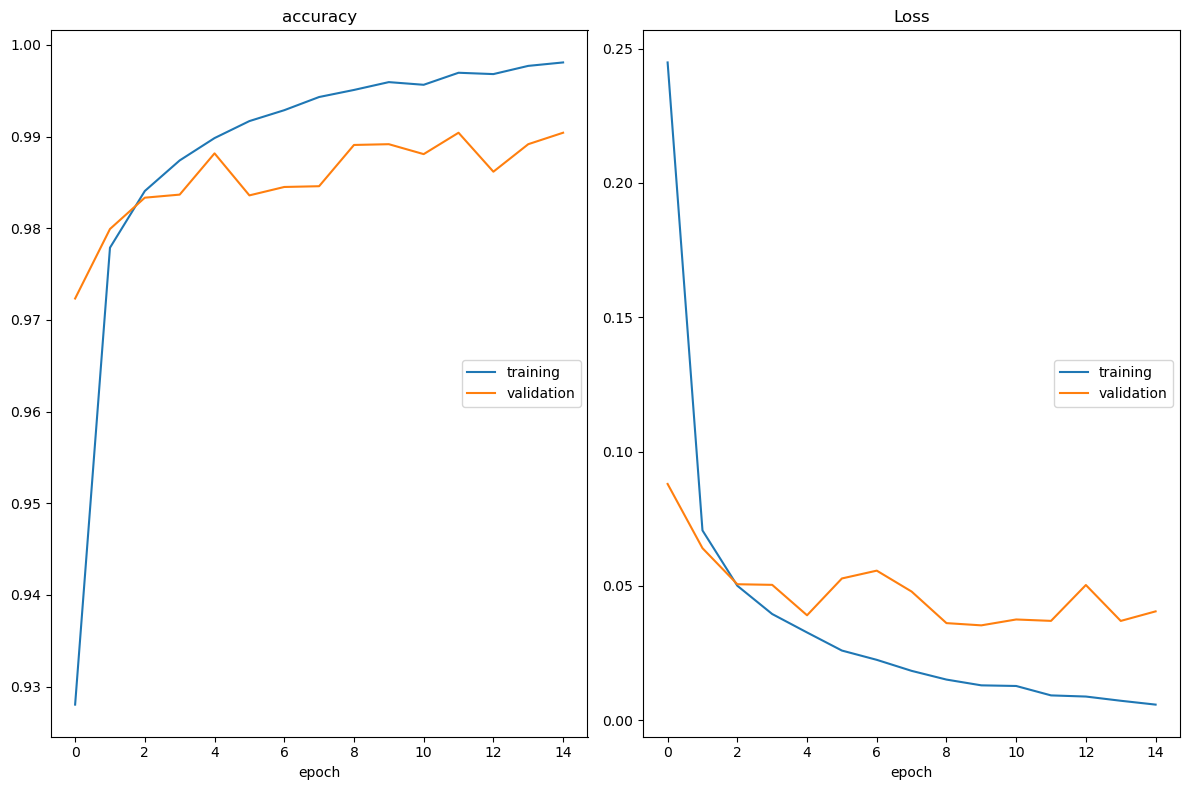

accuracy
	training         	 (min:    0.928, max:    0.998, cur:    0.998)
	validation       	 (min:    0.972, max:    0.990, cur:    0.990)
Loss
	training         	 (min:    0.006, max:    0.245, cur:    0.006)
	validation       	 (min:    0.035, max:    0.088, cur:    0.040)
750/750 [==============================] - 21s 28ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0405 - val_accuracy: 0.9904


In [11]:
train_data = next(iter(train_dl_all))
val_data = next(iter(val_dl_all))

train_features = tf.convert_to_tensor(train_data[0].numpy(), dtype=tf.float32)
train_labels = tf.one_hot(train_data[1], depth=10)

val_features = tf.convert_to_tensor(val_data[0].numpy(), dtype=tf.float32)
val_labels = tf.one_hot(val_data[1], depth=10)

history = model.fit(train_features, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE_TRAIN,
                    validation_data=(val_features, val_labels), callbacks=[PlotLossesKerasTF()], verbose=1)


In [16]:
test_data = next(iter(test_dl_all))

test_features = tf.convert_to_tensor(test_data[0].numpy(), dtype=tf.float32)
test_labels_one_hot = tf.one_hot(test_data[1], depth=10)

predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)

test_labels = np.argmax(test_labels_one_hot.numpy(), axis=1)

print("Accuracy: ", accuracy_score(test_labels, predicted_labels))
print("CNN Model: \n", classification_report(test_labels, predicted_labels))

313/313 [==============================] - 2s 5ms/step
Accuracy:  0.98989898989899
CNN Model: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1027
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999



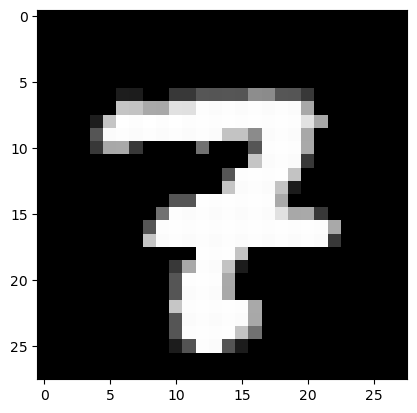

1/1 [==============================] - 0s 23ms/step
Predicted Label: 7


In [37]:
idx = random.randint(0, len(test_dl_all.dataset))
for i, (test_features, _) in enumerate(test_dl_all):
    if idx < len(test_features):
        test_sample = test_features[idx]
        break
    idx -= len(test_features)

test_sample = test_sample.numpy().reshape((1, 28, 28, 1))  # Converter para numpy array e ajustar o formato

plt.imshow(test_sample.squeeze(), cmap='gray')
plt.show()

y_pred = model.predict(test_sample)
predicted_label = np.argmax(y_pred)

print("Predicted Label:", predicted_label)

In [39]:
joblib.dump(model, 'cnnmnist.pkl')

['cnnmnist.pkl']